# Smoothed Disperser transmission study for HD111980


Study the true transmission wrt transmission in simulatio 

- author Sylvie Dagoret-Campagne
- creation date : May 2018
- affliliation : CNRS/IN2P3
- project : DESC-LSST

- need to increase the number of files to be open:

    ulimit -a
    
    ulimit -n 2048
    
    ulimit -Sn 10000

In [122]:
!ulimit -a

core file size          (blocks, -c) 0
data seg size           (kbytes, -d) unlimited
file size               (blocks, -f) unlimited
max locked memory       (kbytes, -l) unlimited
max memory size         (kbytes, -m) unlimited
open files                      (-n) 2048
pipe size            (512 bytes, -p) 1
stack size              (kbytes, -s) 8192
cpu time               (seconds, -t) unlimited
max user processes              (-u) 1418
virtual memory          (kbytes, -v) unlimited


## Setup

### Notebook style

In [123]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

### import

In [124]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
%matplotlib inline
import sys
import os
import pandas as pd
import glob
from matplotlib.backends.backend_pdf import PdfPages 

In [125]:
from scipy import interpolate

In [126]:
import seaborn as sns

In [127]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Figure style

In [128]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 10),   #defines the default image size
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [129]:
plt.rcParams.update({'figure.max_open_warning': 0}) # to see a large number of files

## Initialisation

### Spectractor

In [130]:
PATH_SPECTRACTOR='../../../Spectractor'
PATH_SPECTRACTORSIM='../../../SpectractorSim'
PATH_SPECTRACTORANAATM='../../../SpectractorAnaAtm/common_tools'
PATH_GMAOMERRA='../../merra2'

In [131]:
sys.path.append(PATH_SPECTRACTOR)
sys.path.append(PATH_SPECTRACTORSIM)
sys.path.append(PATH_SPECTRACTORANAATM)
sys.path.append(PATH_GMAOMERRA)

In [132]:
from spectractor import *
from spectractorsim import *
from libspecana import *

## Input spectra

### LogBook

In [133]:
file_logbook_csv=os.path.join(PATH_SPECTRACTOR,'ctiofulllogbook_jun2017_v4.csv')

In [134]:
df_ctio_lbk=pd.read_csv(file_logbook_csv,sep=';')

In [135]:
df_ctio_lbk.columns

Index([u'Unnamed: 0', u'date', u'subdir', u'index', u'object', u'filter',
       u'disperser', u'airmass', u'exposure', u'focus', u'seeing', u'P', u'T',
       u'RH', u'W', u'file', u'Obj-posXpix', u'Obj-posYpix', u'Dx', u'Dy',
       u'comment', u'skip'],
      dtype='object')

In [136]:
df_ctio_lbk=df_ctio_lbk.reindex(columns=['date','index','P','T','RH','airmass','seeing','exposure','object','filter','disperser','focus','W','subdir','file']).set_index('date').sort_index()

### Spectra Data

In [137]:
home=os.getenv('HOME')

In [138]:
path_data=os.path.join(home,'DATA/CTIODataJune2017_reduced_RG715_v2_prod1')
#path_data=os.path.join('/sps/lsst/data/AtmosphericCalibration','CTIODataJune2017_reduced_RG715_v2_prod1')

In [139]:
All_Subdirs=np.array(['data_28may17','data_29may17','data_30may17','data_31may17','data_01jun17','data_02jun17',
            'data_03jun17','data_04jun17','data_06jun17','data_08jun17','data_09jun17','data_10jun17',
            'data_12jun17','data_13jun17'])

In [140]:
Flag_Photometric_Nights=np.array([False,False,True,False,False,False,False,False,False,True,False,True,True,False])

In [141]:
photometric_indexes=np.where(Flag_Photometric_Nights)[0]

In [142]:
print 'Photometric indexes : ',photometric_indexes

Photometric indexes :  [ 2  9 11 12]


In [143]:
print 'Photometric nights : ',All_Subdirs[photometric_indexes]

Photometric nights :  ['data_30may17' 'data_08jun17' 'data_10jun17' 'data_12jun17']


### Sim spectra

In [144]:
PATH_SPECTRACTORSIM

'../../../SpectractorAnaAtm/common_tools/../../SpectractorSim'

In [145]:
# laptop:
path_sim=os.path.join(PATH_SPECTRACTORSIM,'sim_prod/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra')
# CCIN2P3:
#path_sim=PATH_SPECTRACTORSIM+'/sim_prod/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra'
# Office desktop
home=os.getenv('HOME')
path_sim=os.path.join(home,'DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra')

In [146]:
path_sim

'/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra'

## Selection of night

In [147]:
date="20170530"

In [148]:
idx_sel_subdir=2

In [149]:
SelectTagRe='^reduc_%s_([0-9]+)_spectrum.fits$' % (date)

### Logbook

In [150]:
all_obs=df_ctio_lbk.loc[(df_ctio_lbk["subdir"]==All_Subdirs[idx_sel_subdir])].sort_index()

In [151]:
all_obs_extr=all_obs[["index","object"]]

### Wavelength correction

In [152]:
FLAG_WL_CORRECTION=True # specify if correction on wavelength can be performed from input file
file_wavelengthshift="../wavelength_shift.csv"
wlshift=pd.read_csv(file_wavelengthshift)

In [153]:
wlshift.head()

,index,wlshift
0,57,-6.633933
1,58,-3.083037
2,60,-8.383797
3,61,-2.846134
4,62,-5.646836


### path for spectra

In [154]:
path_spectra=os.path.join(path_data,All_Subdirs[idx_sel_subdir])
path_spectrasim=os.path.join(path_sim,All_Subdirs[idx_sel_subdir])

### find filename for data spectra

In [155]:
search_string=os.path.join(path_spectra,'*.fits')
all_spectrafiles=glob.glob(search_string)
all_spectrafiles=sorted(all_spectrafiles)

### extract the index from the data spectra filename

In [156]:
#SelectTagRe='^reduc_%s_([0-9]+)_spectrum.fits$' % (date)
all_sel_indexes=[]
for ffn in all_spectrafiles:
    all_sel_indexes.append(get_index_from_filename(ffn,SelectTagRe))
all_sel_indexes=np.array(all_sel_indexes)    

### extract the logbook rows corrsponding to the spectra

- use the indexes obtained to extract the relevant rows from the logbook

In [157]:
sel_obs=all_obs.loc[all_obs['index'].isin(all_sel_indexes)]

In [158]:
sel_obs.head()

,index,P,T,RH,airmass,seeing,exposure,object,filter,disperser,focus,W,subdir,file
date,,,,,,,,,,,,,,
2017-05-31T00:00:26.147,57,783,"9,3",26,"1,053","1,14",60,HD111980,dia,Ron400,12450,"5,7",data_30may17,reduc_20170530_057.fits
2017-05-31T00:02:18.596,58,783,"9,3",26,"1,051","0,94",60,HD111980,dia,Thor300,12450,"5,5",data_30may17,reduc_20170530_058.fits
2017-05-31T00:06:14.000,60,783,"9,1",26,"1,047","1,018",60,HD111980,dia,Ron400,12450,"5,7",data_30may17,reduc_20170530_060.fits
2017-05-31T00:08:06.454,61,783,"9,2",26,"1,045","0,939",60,HD111980,dia,Thor300,12450,"5,5",data_30may17,reduc_20170530_061.fits
2017-05-31T00:09:58.852,62,783,"9,1",26,"1,044","0,846",60,HD111980,dia,HoloPhP,12450,"5,8",data_30may17,reduc_20170530_062.fits


In [159]:
sel_obs.tail()

,index,P,T,RH,airmass,seeing,exposure,object,filter,disperser,focus,W,subdir,file
date,,,,,,,,,,,,,,
2017-05-31T10:33:46.896,280,782,11,20,"1,018","0,793",60,HD205905,dia,Ron400,12400,"14,5",data_30may17,reduc_20170530_280.fits
2017-05-31T10:35:39.245,281,782,"11,2",20,"1,019","0,793",60,HD205905,dia,Thor300,12400,"13,1",data_30may17,reduc_20170530_281.fits
2017-05-31T10:37:31.598,282,782,11,20,"1,021","0,793",60,HD205905,dia,HoloPhP,12400,"12,5",data_30may17,reduc_20170530_282.fits
2017-05-31T10:39:24.046,283,782,11,20,"1,022","0,793",120,HD205905,dia,HoloPhAg,12400,"12,8",data_30may17,reduc_20170530_283.fits
2017-05-31T10:42:16.450,284,782,11,20,"1,024","0,793",120,HD205905,dia,HoloAmAg,12400,"13,2",data_30may17,reduc_20170530_284.fits


### Quick view on the kind of sources

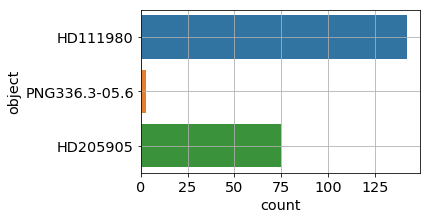

In [160]:
plt.figure(figsize=(5,3))
sns.countplot(y='object', data=sel_obs)
plt.grid(True)

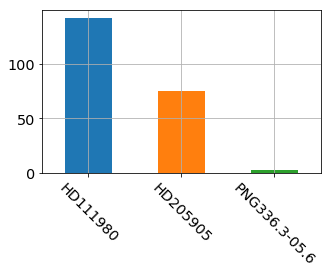

In [161]:
plt.figure(figsize=(5,3))
sel_obs['object'].value_counts().plot(kind='bar',rot=0)
plt.xticks(rotation=-45)
plt.grid(True)

### Remove bad spectra

In [162]:
bad_obs_0=sel_obs.loc[sel_obs['index'].isin([57])]

In [163]:
bad_obs_0

,index,P,T,RH,airmass,seeing,exposure,object,filter,disperser,focus,W,subdir,file
date,,,,,,,,,,,,,,
2017-05-31T00:00:26.147,57,783,"9,3",26,"1,053","1,14",60,HD111980,dia,Ron400,12450,"5,7",data_30may17,reduc_20170530_057.fits


### Remove bad sources

- remove star **PNG336.3-05.6**

In [164]:
bad_obs=sel_obs.loc[sel_obs['object'].isin(['PNG336.3-05.6','HD205905'])]
bad_indexes=bad_obs["index"]

In [165]:
bad_obs

,index,P,T,RH,airmass,seeing,exposure,object,filter,disperser,focus,W,subdir,file
date,,,,,,,,,,,,,,
2017-05-31T05:56:35.901,200,783,"9,3",23,"1,089","0,829",300,PNG336.3-05.6,dia,Thor300,12450,7,data_30may17,reduc_20170530_200.fits
2017-05-31T06:05:21.701,201,783,"9,4",23,"1,095","0,737",600,PNG336.3-05.6,dia,HoloPhP,12450,"8,5",data_30may17,reduc_20170530_201.fits
2017-05-31T07:03:12.652,205,783,"9,5",24,"1,158","0,941",600,PNG336.3-05.6,dia,HoloPhP,12400,"10,8",data_30may17,reduc_20170530_205.fits
2017-05-31T07:54:38.806,210,782,"9,5",23,"1,101","0,793",60,HD205905,dia,Ron400,12400,"11,6",data_30may17,reduc_20170530_210.fits
2017-05-31T07:56:31.293,211,782,"9,4",24,"1,097","0,793",60,HD205905,dia,Thor300,12400,"11,5",data_30may17,reduc_20170530_211.fits
2017-05-31T07:58:23.653,212,782,"9,5",24,"1,094","0,793",60,HD205905,dia,HoloPhP,12400,"10,5",data_30may17,reduc_20170530_212.fits
2017-05-31T08:00:16.053,213,782,"9,7",23,"1,09","0,793",120,HD205905,dia,HoloPhAg,12400,12,data_30may17,reduc_20170530_213.fits
2017-05-31T08:03:08.495,214,782,"9,6",23,"1,085","0,793",120,HD205905,dia,HoloAmAg,12400,"13,4",data_30may17,reduc_20170530_214.fits
2017-05-31T08:06:00.847,215,782,"9,6",23,"1,08","0,793",60,HD205905,dia,Ron400,12400,"15,4",data_30may17,reduc_20170530_215.fits


In [166]:
bad_indexes=bad_obs.loc[:,"index"]

In [167]:
bad_indexes.index

Index([u'2017-05-31T05:56:35.901', u'2017-05-31T06:05:21.701',
       u'2017-05-31T07:03:12.652', u'2017-05-31T07:54:38.806',
       u'2017-05-31T07:56:31.293', u'2017-05-31T07:58:23.653',
       u'2017-05-31T08:00:16.053', u'2017-05-31T08:03:08.495',
       u'2017-05-31T08:06:00.847', u'2017-05-31T08:07:53.254',
       u'2017-05-31T08:09:45.655', u'2017-05-31T08:11:37.854',
       u'2017-05-31T08:14:30.301', u'2017-05-31T08:17:22.698',
       u'2017-05-31T08:19:15.101', u'2017-05-31T08:21:07.405',
       u'2017-05-31T08:22:59.809', u'2017-05-31T08:25:52.205',
       u'2017-05-31T08:28:44.549', u'2017-05-31T08:30:37.007',
       u'2017-05-31T08:32:29.446', u'2017-05-31T08:34:21.908',
       u'2017-05-31T08:37:14.395', u'2017-05-31T08:40:06.801',
       u'2017-05-31T08:41:59.205', u'2017-05-31T08:43:51.549',
       u'2017-05-31T08:45:44.007', u'2017-05-31T08:48:36.303',
       u'2017-05-31T08:51:28.895', u'2017-05-31T08:53:21.253',
       u'2017-05-31T08:55:13.701', u'2017-05-31T08:57:0

In [168]:
bad_indexes.values

array([200, 201, 205, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,
       220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232,
       233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245,
       246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258,
       259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271,
       272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284])

### Concatenate bad obs

In [169]:
bad_obs=pd.concat([bad_obs,bad_obs_0])

In [170]:
bad_obs

,index,P,T,RH,airmass,seeing,exposure,object,filter,disperser,focus,W,subdir,file
date,,,,,,,,,,,,,,
2017-05-31T05:56:35.901,200,783,"9,3",23,"1,089","0,829",300,PNG336.3-05.6,dia,Thor300,12450,7,data_30may17,reduc_20170530_200.fits
2017-05-31T06:05:21.701,201,783,"9,4",23,"1,095","0,737",600,PNG336.3-05.6,dia,HoloPhP,12450,"8,5",data_30may17,reduc_20170530_201.fits
2017-05-31T07:03:12.652,205,783,"9,5",24,"1,158","0,941",600,PNG336.3-05.6,dia,HoloPhP,12400,"10,8",data_30may17,reduc_20170530_205.fits
2017-05-31T07:54:38.806,210,782,"9,5",23,"1,101","0,793",60,HD205905,dia,Ron400,12400,"11,6",data_30may17,reduc_20170530_210.fits
2017-05-31T07:56:31.293,211,782,"9,4",24,"1,097","0,793",60,HD205905,dia,Thor300,12400,"11,5",data_30may17,reduc_20170530_211.fits
2017-05-31T07:58:23.653,212,782,"9,5",24,"1,094","0,793",60,HD205905,dia,HoloPhP,12400,"10,5",data_30may17,reduc_20170530_212.fits
2017-05-31T08:00:16.053,213,782,"9,7",23,"1,09","0,793",120,HD205905,dia,HoloPhAg,12400,12,data_30may17,reduc_20170530_213.fits
2017-05-31T08:03:08.495,214,782,"9,6",23,"1,085","0,793",120,HD205905,dia,HoloAmAg,12400,"13,4",data_30may17,reduc_20170530_214.fits
2017-05-31T08:06:00.847,215,782,"9,6",23,"1,08","0,793",60,HD205905,dia,Ron400,12400,"15,4",data_30may17,reduc_20170530_215.fits


In [171]:
bad_obs.sort_values(by="index",inplace=True)

In [172]:
bad_indexes=bad_obs.loc[:,"index"]

In [173]:
bad_indexes.index

Index([u'2017-05-31T00:00:26.147', u'2017-05-31T05:56:35.901',
       u'2017-05-31T06:05:21.701', u'2017-05-31T07:03:12.652',
       u'2017-05-31T07:54:38.806', u'2017-05-31T07:56:31.293',
       u'2017-05-31T07:58:23.653', u'2017-05-31T08:00:16.053',
       u'2017-05-31T08:03:08.495', u'2017-05-31T08:06:00.847',
       u'2017-05-31T08:07:53.254', u'2017-05-31T08:09:45.655',
       u'2017-05-31T08:11:37.854', u'2017-05-31T08:14:30.301',
       u'2017-05-31T08:17:22.698', u'2017-05-31T08:19:15.101',
       u'2017-05-31T08:21:07.405', u'2017-05-31T08:22:59.809',
       u'2017-05-31T08:25:52.205', u'2017-05-31T08:28:44.549',
       u'2017-05-31T08:30:37.007', u'2017-05-31T08:32:29.446',
       u'2017-05-31T08:34:21.908', u'2017-05-31T08:37:14.395',
       u'2017-05-31T08:40:06.801', u'2017-05-31T08:41:59.205',
       u'2017-05-31T08:43:51.549', u'2017-05-31T08:45:44.007',
       u'2017-05-31T08:48:36.303', u'2017-05-31T08:51:28.895',
       u'2017-05-31T08:53:21.253', u'2017-05-31T08:55:1

In [174]:
bad_indexes.values

array([ 57, 200, 201, 205, 210, 211, 212, 213, 214, 215, 216, 217, 218,
       219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231,
       232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244,
       245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257,
       258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270,
       271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284])

- keep stars **HD111980**, **HD205905**

In [175]:
sel2_obs=sel_obs.loc[sel_obs['object'].isin(['HD111980'])]

In [176]:
!pwd

/Users/dagoret/MacOSX/GitHub/LSST/SpectractorAnaAtm/ana_30may17/HD111980


In [177]:
sel2_obs=sel2_obs[sel2_obs.index !=57]      # REMOVE 57

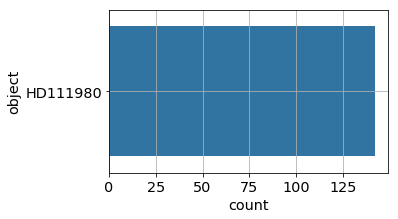

In [178]:
plt.figure(figsize=(5,3))
sns.countplot(y='object', data=sel2_obs)
plt.grid(True)

#### Make a list of the object names

In [179]:
list_of_objects=sel2_obs['object'].values

In [180]:
list_of_objects=set(list_of_objects)

In [181]:
list_of_objects=list(list_of_objects)

In [182]:
list_of_objects_str=','.join(list_of_objects)

### find filename for sim spectra

In [183]:
path_sim1=os.path.join(path_spectrasim,'clearsky')
path_sim2=os.path.join(path_spectrasim,'standard')
path_sim3=os.path.join(path_spectrasim,'merra2')

In [184]:
search_string=os.path.join(path_sim1,'*.fits')
all_simspectrafiles1=glob.glob(search_string)
all_simspectrafiles1=sorted(all_simspectrafiles1)

In [185]:
all_simspectrafiles1[:3]

['/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra/data_30may17/clearsky/specsim_20170530_057_spectrum.fits',
 '/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra/data_30may17/clearsky/specsim_20170530_058_spectrum.fits',
 '/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra/data_30may17/clearsky/specsim_20170530_060_spectrum.fits']

In [186]:
search_string=os.path.join(path_sim2,'*.fits')
all_simspectrafiles2=glob.glob(search_string)
all_simspectrafiles2=sorted(all_simspectrafiles2)

In [187]:
all_simspectrafiles2[:3]

['/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra/data_30may17/standard/specsim_20170530_057_spectrum.fits',
 '/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra/data_30may17/standard/specsim_20170530_058_spectrum.fits',
 '/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra/data_30may17/standard/specsim_20170530_060_spectrum.fits']

In [188]:
search_string=os.path.join(path_sim3,'*.fits')
all_simspectrafiles3=glob.glob(search_string)
all_simspectrafiles3=sorted(all_simspectrafiles3)

In [189]:
all_simspectrafiles3[:3]

['/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra/data_30may17/merra2/specsim_20170530_057_spectrum.fits',
 '/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra/data_30may17/merra2/specsim_20170530_058_spectrum.fits',
 '/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra/data_30may17/merra2/specsim_20170530_060_spectrum.fits']

# Remove bad indexes

In [190]:
file_toremove=[]
SelectTagRe='^reduc_%s_([0-9]+)_spectrum.fits$' % (date)
for ffn in all_spectrafiles:
    fn=ffn.split('/')[-1]
    sel_index= int(re.findall(SelectTagRe,fn)[0])
    if sel_index in bad_indexes.values:
        print ' remove ', fn
        file_toremove.append(ffn)
for f in file_toremove:
    all_spectrafiles.remove(f)        

 remove  reduc_20170530_057_spectrum.fits
 remove  reduc_20170530_200_spectrum.fits
 remove  reduc_20170530_201_spectrum.fits
 remove  reduc_20170530_205_spectrum.fits
 remove  reduc_20170530_210_spectrum.fits
 remove  reduc_20170530_211_spectrum.fits
 remove  reduc_20170530_212_spectrum.fits
 remove  reduc_20170530_213_spectrum.fits
 remove  reduc_20170530_214_spectrum.fits
 remove  reduc_20170530_215_spectrum.fits
 remove  reduc_20170530_216_spectrum.fits
 remove  reduc_20170530_217_spectrum.fits
 remove  reduc_20170530_218_spectrum.fits
 remove  reduc_20170530_219_spectrum.fits
 remove  reduc_20170530_220_spectrum.fits
 remove  reduc_20170530_221_spectrum.fits
 remove  reduc_20170530_222_spectrum.fits
 remove  reduc_20170530_223_spectrum.fits
 remove  reduc_20170530_224_spectrum.fits
 remove  reduc_20170530_225_spectrum.fits
 remove  reduc_20170530_226_spectrum.fits
 remove  reduc_20170530_227_spectrum.fits
 remove  reduc_20170530_228_spectrum.fits
 remove  reduc_20170530_229_spectr

In [191]:
file_toremove=[]
SelectTagRe='^specsim_%s_([0-9]+)_spectrum.fits$' % (date)
for ffn in all_simspectrafiles1:
    fn=ffn.split('/')[-1]
    sel_index= int(re.findall(SelectTagRe,fn)[0])
    if sel_index in bad_indexes.values:
        print ' remove ', fn
        file_toremove.append(ffn)
for f in file_toremove:
    all_simspectrafiles1.remove(f)   

 remove  specsim_20170530_057_spectrum.fits
 remove  specsim_20170530_200_spectrum.fits
 remove  specsim_20170530_201_spectrum.fits
 remove  specsim_20170530_205_spectrum.fits
 remove  specsim_20170530_210_spectrum.fits
 remove  specsim_20170530_211_spectrum.fits
 remove  specsim_20170530_212_spectrum.fits
 remove  specsim_20170530_213_spectrum.fits
 remove  specsim_20170530_214_spectrum.fits
 remove  specsim_20170530_215_spectrum.fits
 remove  specsim_20170530_216_spectrum.fits
 remove  specsim_20170530_217_spectrum.fits
 remove  specsim_20170530_218_spectrum.fits
 remove  specsim_20170530_219_spectrum.fits
 remove  specsim_20170530_220_spectrum.fits
 remove  specsim_20170530_221_spectrum.fits
 remove  specsim_20170530_222_spectrum.fits
 remove  specsim_20170530_223_spectrum.fits
 remove  specsim_20170530_224_spectrum.fits
 remove  specsim_20170530_225_spectrum.fits
 remove  specsim_20170530_226_spectrum.fits
 remove  specsim_20170530_227_spectrum.fits
 remove  specsim_20170530_228_sp

In [192]:
file_toremove=[]
SelectTagRe='^specsim_%s_([0-9]+)_spectrum.fits$' % (date)
for ffn in all_simspectrafiles2:
    fn=ffn.split('/')[-1]
    sel_index= int(re.findall(SelectTagRe,fn)[0])
    if sel_index in bad_indexes.values:
        print ' remove ', fn
        file_toremove.append(ffn)
for f in file_toremove:
    all_simspectrafiles2.remove(f)

 remove  specsim_20170530_057_spectrum.fits
 remove  specsim_20170530_200_spectrum.fits
 remove  specsim_20170530_201_spectrum.fits
 remove  specsim_20170530_205_spectrum.fits
 remove  specsim_20170530_210_spectrum.fits
 remove  specsim_20170530_211_spectrum.fits
 remove  specsim_20170530_212_spectrum.fits
 remove  specsim_20170530_213_spectrum.fits
 remove  specsim_20170530_214_spectrum.fits
 remove  specsim_20170530_215_spectrum.fits
 remove  specsim_20170530_216_spectrum.fits
 remove  specsim_20170530_217_spectrum.fits
 remove  specsim_20170530_218_spectrum.fits
 remove  specsim_20170530_219_spectrum.fits
 remove  specsim_20170530_220_spectrum.fits
 remove  specsim_20170530_221_spectrum.fits
 remove  specsim_20170530_222_spectrum.fits
 remove  specsim_20170530_223_spectrum.fits
 remove  specsim_20170530_224_spectrum.fits
 remove  specsim_20170530_225_spectrum.fits
 remove  specsim_20170530_226_spectrum.fits
 remove  specsim_20170530_227_spectrum.fits
 remove  specsim_20170530_228_sp

In [193]:
file_toremove=[]
SelectTagRe='^specsim_%s_([0-9]+)_spectrum.fits$' % (date)
for ffn in all_simspectrafiles3:
    fn=ffn.split('/')[-1]
    sel_index= int(re.findall(SelectTagRe,fn)[0])
    if sel_index in bad_indexes.values:
        print ' remove ', fn
        file_toremove.append(ffn)
for f in file_toremove:
    all_simspectrafiles3.remove(f)

 remove  specsim_20170530_057_spectrum.fits
 remove  specsim_20170530_200_spectrum.fits
 remove  specsim_20170530_201_spectrum.fits
 remove  specsim_20170530_205_spectrum.fits
 remove  specsim_20170530_210_spectrum.fits
 remove  specsim_20170530_211_spectrum.fits
 remove  specsim_20170530_212_spectrum.fits
 remove  specsim_20170530_213_spectrum.fits
 remove  specsim_20170530_214_spectrum.fits
 remove  specsim_20170530_215_spectrum.fits
 remove  specsim_20170530_216_spectrum.fits
 remove  specsim_20170530_217_spectrum.fits
 remove  specsim_20170530_218_spectrum.fits
 remove  specsim_20170530_219_spectrum.fits
 remove  specsim_20170530_220_spectrum.fits
 remove  specsim_20170530_221_spectrum.fits
 remove  specsim_20170530_222_spectrum.fits
 remove  specsim_20170530_223_spectrum.fits
 remove  specsim_20170530_224_spectrum.fits
 remove  specsim_20170530_225_spectrum.fits
 remove  specsim_20170530_226_spectrum.fits
 remove  specsim_20170530_227_spectrum.fits
 remove  specsim_20170530_228_sp

# which filters

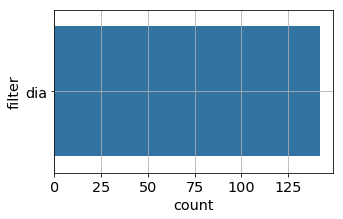

In [194]:
plt.figure(figsize=(5,3))
sns.countplot(y='filter', data=sel2_obs)
plt.grid(True)

# which are the dispersers ?

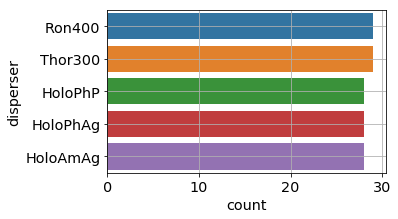

In [195]:
plt.figure(figsize=(5,3))
sns.countplot(y='disperser', data=sel2_obs)
plt.grid(True)

In [196]:
sel_obs_Ron400=sel2_obs.loc[sel2_obs['disperser'].isin(['Ron400'])]

In [197]:
sel_obs_Thor300=sel2_obs.loc[sel2_obs['disperser'].isin(['Thor300'])]

In [198]:
sel_obs_HoloPhP=sel2_obs.loc[sel2_obs['disperser'].isin(['HoloPhP'])]

In [199]:
sel_obs_HoloPhAg=sel2_obs.loc[sel2_obs['disperser'].isin(['HoloPhAg'])]

In [200]:
sel_obs_HoloAmAg=sel2_obs.loc[sel2_obs['disperser'].isin(['HoloAmAg'])]

# Show the spectra

## The original SED

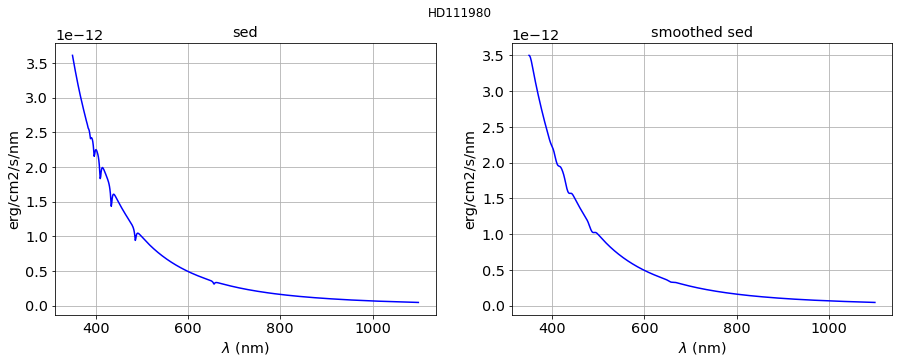

In [201]:
PlotSED(list_of_objects_str)

## Show the reconstructed spectra

In [202]:
SearchTagRe='^reduc_%s_([0-9]+)_spectrum.fits$' % (date)
print SearchTagRe

^reduc_20170530_([0-9]+)_spectrum.fits$


### Ronchi 400 spectra

In [203]:
thetitle="Smoothed Reconstructed spectra for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Ronchi400"

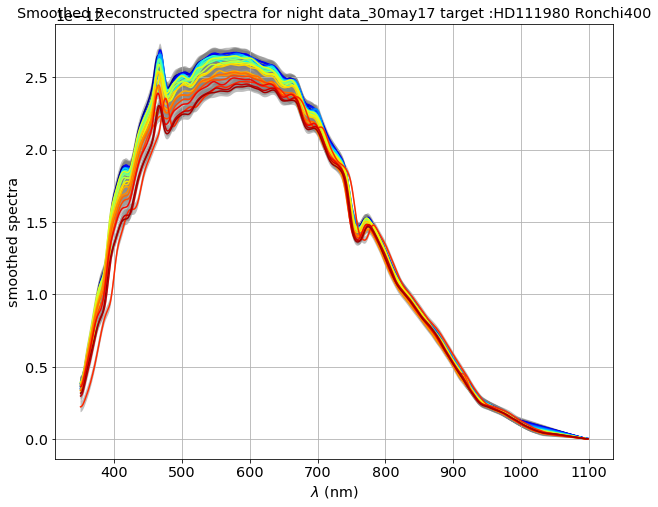

In [204]:
PlotSpectraDataSimSmooth(all_spectrafiles,sel_obs_Ron400,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True)

### Thor 300

In [205]:
thetitle="Reconstructed smoothed spectra for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Thor300"

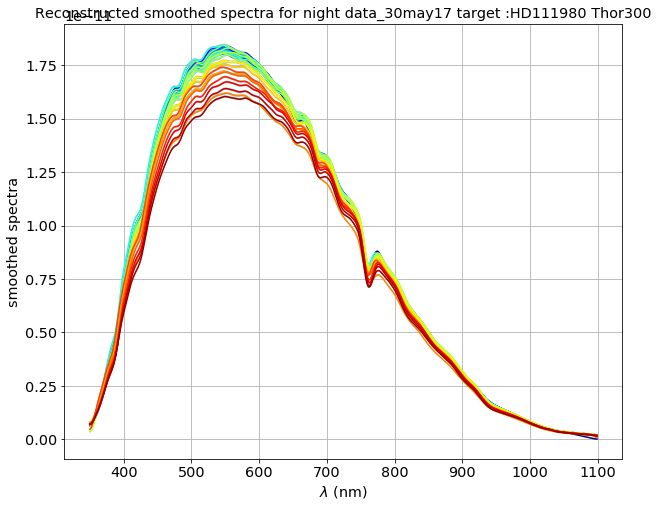

In [206]:
PlotSpectraDataSimSmooth(all_spectrafiles,sel_obs_Thor300,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True)

### HoloPhP

In [207]:
thetitle="Reconstructed smooth spectra for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloPhP"

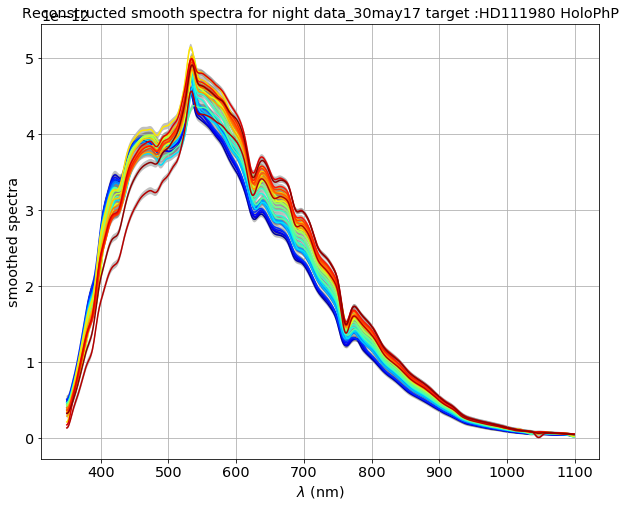

In [208]:
PlotSpectraDataSimSmooth(all_spectrafiles,sel_obs_HoloPhP,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True)

### HoloPhAg

In [209]:
thetitle="Reconstructed smooth spectra for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloPhAg"

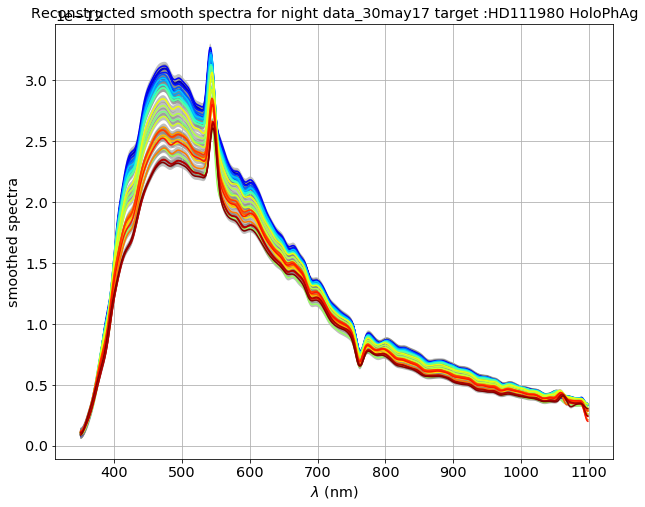

In [210]:
PlotSpectraDataSimSmooth(all_spectrafiles,sel_obs_HoloPhAg,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True)

### HoloAmAg

In [211]:
thetitle="Reconstructed smoothed spectra for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloAmAg"

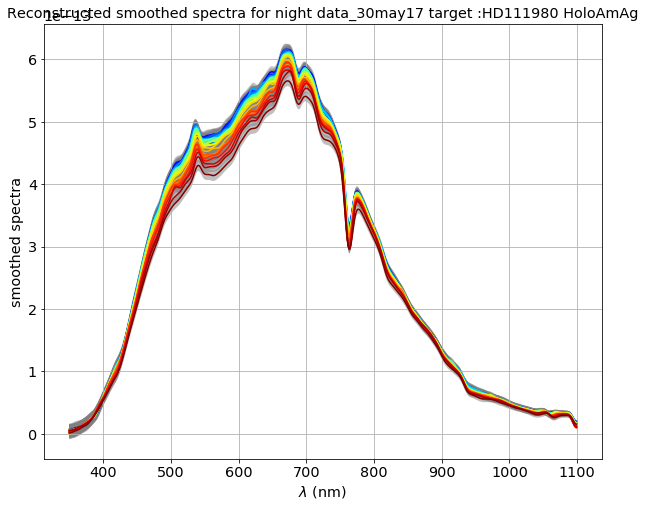

In [212]:
PlotSpectraDataSimSmooth(all_spectrafiles,sel_obs_HoloAmAg,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True)

## Show the simulated spectra

In [213]:
SearchTagRe='^specsim_%s_([0-9]+)_spectrum.fits$' % (date)

### Clear sky

In [214]:
thetitle="Smoothed sim spectra for night (clearsky) "+All_Subdirs[idx_sel_subdir]+' target :'+list_of_objects_str

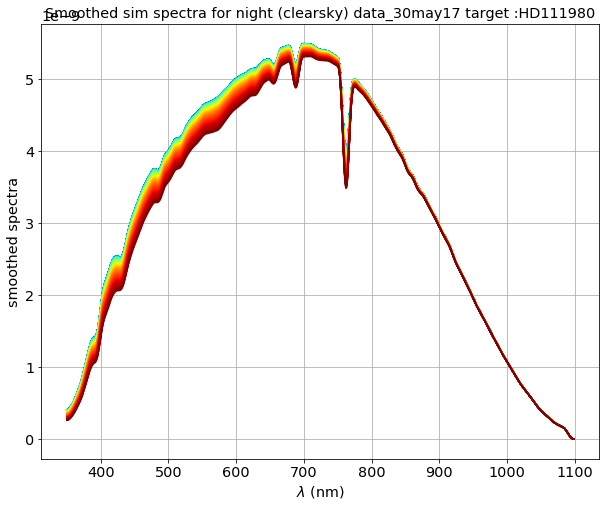

In [215]:
PlotSpectraDataSimSmooth(all_simspectrafiles1,sel2_obs,SearchTagRe,np.zeros(len(wlshift)),thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=False)

### standard sky

In [216]:
thetitle="Smoothed sim spectra for night (standard) "+All_Subdirs[idx_sel_subdir]+' target :'+list_of_objects_str

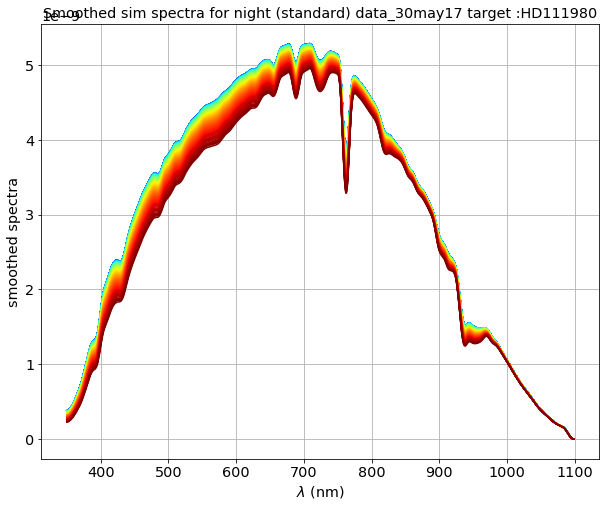

In [217]:
PlotSpectraDataSimSmooth(all_simspectrafiles2,sel2_obs,SearchTagRe,np.zeros(len(wlshift)),thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=False)

### merra2 sky

In [218]:
thetitle="Smoothed sim spectra for night (merra2) "+All_Subdirs[idx_sel_subdir]+' target :'+list_of_objects_str

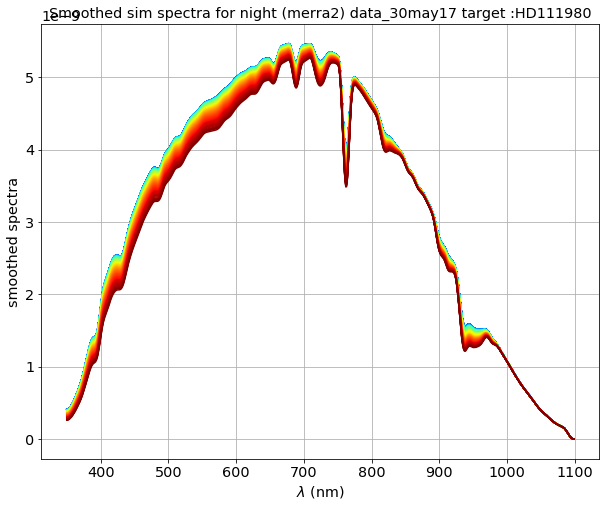

In [219]:
PlotSpectraDataSimSmooth(all_simspectrafiles3,sel2_obs,SearchTagRe,np.zeros(len(wlshift)),thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=False)

# airmass vs index

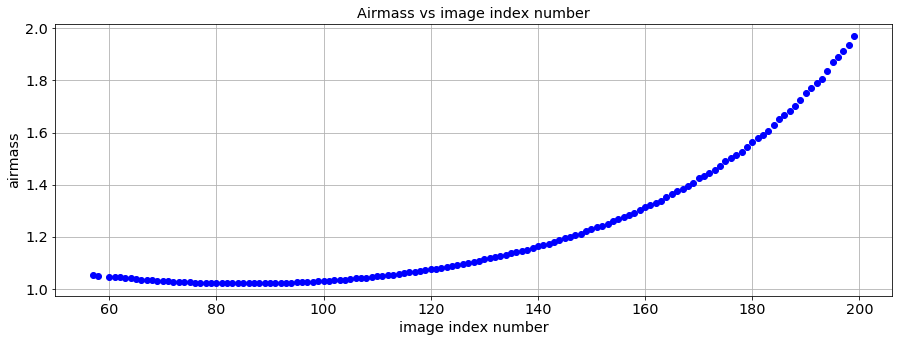

In [220]:
plt.figure(figsize=(15,5))
plt.plot(sel2_obs["index"],Convert_InFloat(sel2_obs["airmass"]),'bo')
plt.xlabel("image index number")
plt.ylabel("airmass")
plt.title('Airmass vs image index number')
plt.grid()

# Spectra ratio data/sim

In [221]:
SearchTagRe='^reduc_%s_([0-9]+)_spectrum.fits$' % (date)

## spectra ratio for Ronchi 400

In [222]:
thetitle="Spectra ratio Data/Sim for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Ronchi400"

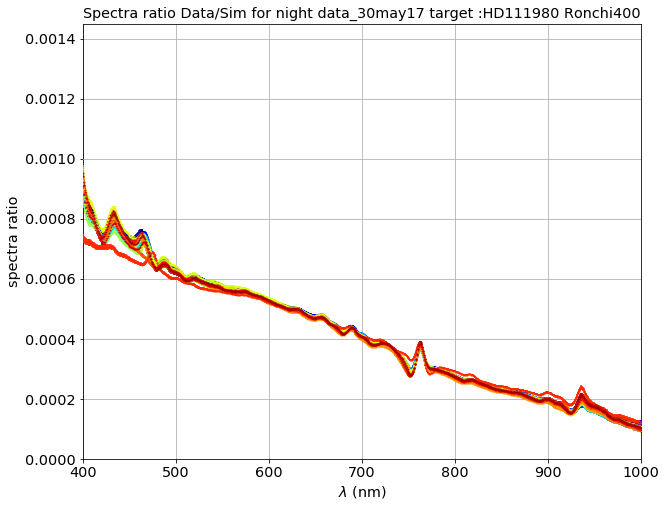

In [223]:
PlotSpectraRatioDataDivSimSmooth(all_spectrafiles,path_sim3,sel_obs_Ron400,SearchTagRe,wlshift,thetitle,
                     FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=400,XMAX=1000.,YMIN=0,YMAX=0)

the_Y_min,the_Y_max = 3.16936159308e-05 0.00289732318093


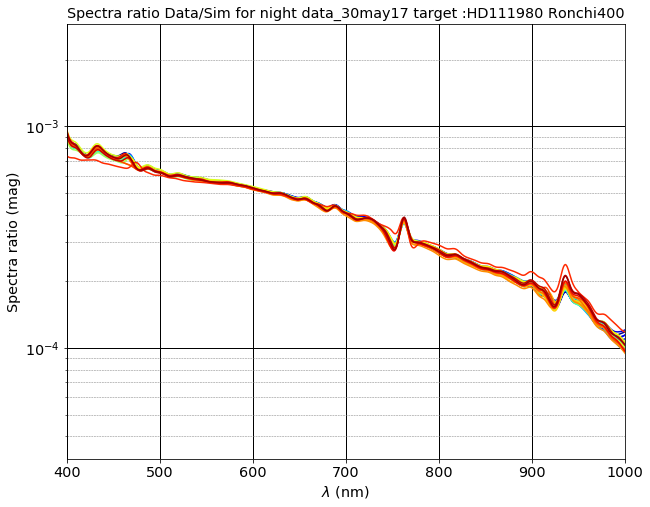

In [224]:
PlotSpectraLogRatioDataDivSimSmooth(all_spectrafiles,path_sim3,sel_obs_Ron400,SearchTagRe,wlshift,thetitle,
                     FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=400,XMAX=1000.,YMIN=0,YMAX=0)

In [225]:
the_ratio_file="ratiosmooth_Ron400.fits"
arr=SaveSpectraRatioDataDivSimSmooth(all_spectrafiles,path_sim3,sel_obs_Ron400,SearchTagRe,wlshift,the_ratio_file,FLAG_WL_CORRECTION,Flag_corr_wl=True)

../../../SpectractorAnaAtm/common_tools/libspecana.py:954: RuntimeWarning: divide by zero encountered in divide
  
../../../SpectractorAnaAtm/common_tools/libspecana.py:954: RuntimeWarning: invalid value encountered in divide
  


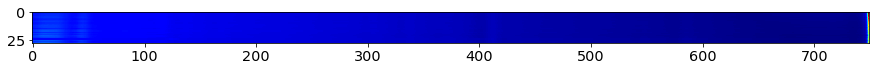

In [226]:
plt.imshow(arr[1:,:],cmap='jet')

## spectra ratio for Thor300

In [227]:
thetitle="Spectra ratio Data/Sim for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Thor300"

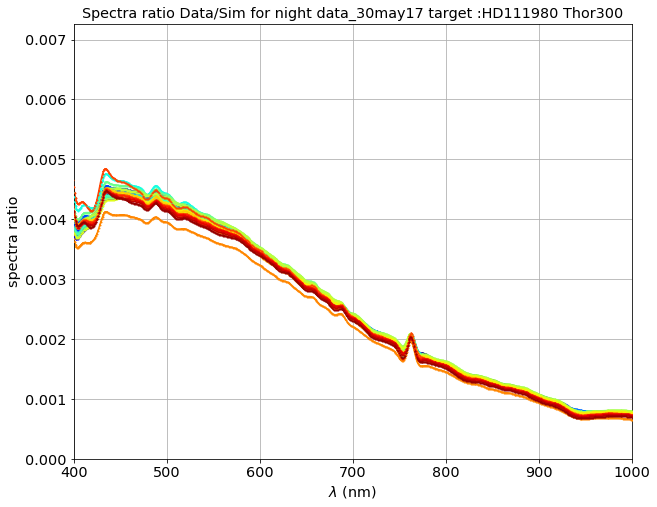

In [228]:
PlotSpectraRatioDataDivSimSmooth(all_spectrafiles,path_sim1,sel_obs_Thor300,SearchTagRe,wlshift,thetitle,
                     FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=400,XMAX=1000.,YMIN=0,YMAX=0)

the_Y_min,the_Y_max = 0.000217412882347 0.0145208487006


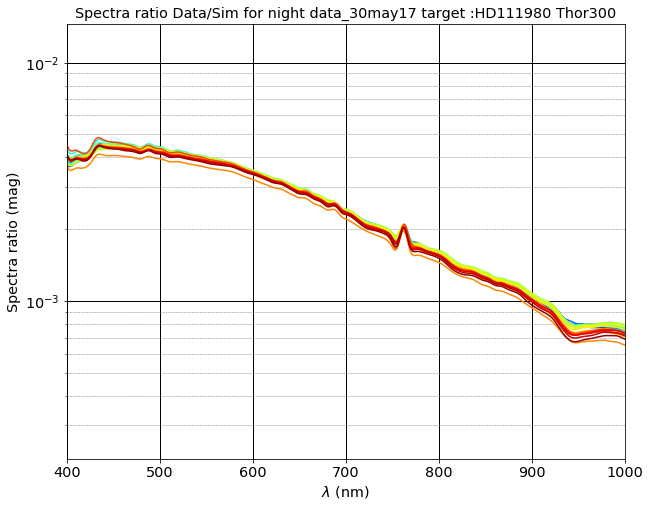

In [229]:
PlotSpectraLogRatioDataDivSimSmooth(all_spectrafiles,path_sim1,sel_obs_Thor300,SearchTagRe,wlshift,thetitle,
                     FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=400,XMAX=1000.,YMIN=0,YMAX=0)

In [230]:
the_ratio_file="ratiosmooth_Thor300.fits"
arr=SaveSpectraRatioDataDivSimSmooth(all_spectrafiles,path_sim1,sel_obs_Thor300,SearchTagRe,wlshift,the_ratio_file,FLAG_WL_CORRECTION,Flag_corr_wl=True)

## spectra ratio for HoloPhP

In [231]:
thetitle="Spectra ratio Data/Sim for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloPhP"

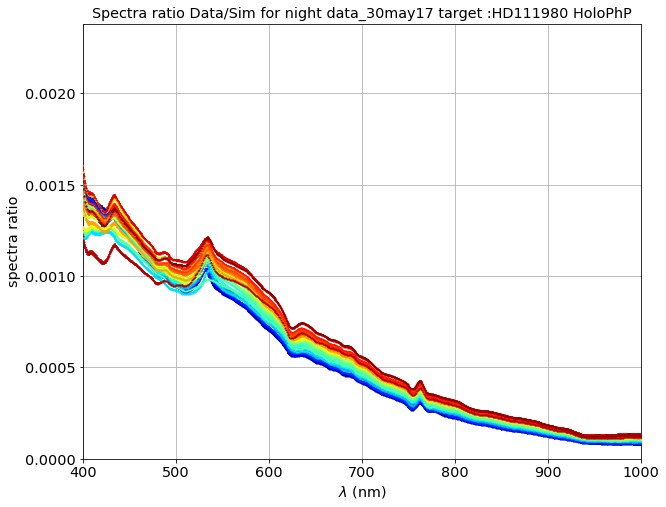

In [232]:
PlotSpectraRatioDataDivSimSmooth(all_spectrafiles,path_sim1,sel_obs_HoloPhP,SearchTagRe,wlshift,thetitle,
                     FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=400,XMAX=1000.,YMIN=0,YMAX=0)

the_Y_min,the_Y_max = 2.64237139959e-05 0.00476025237091


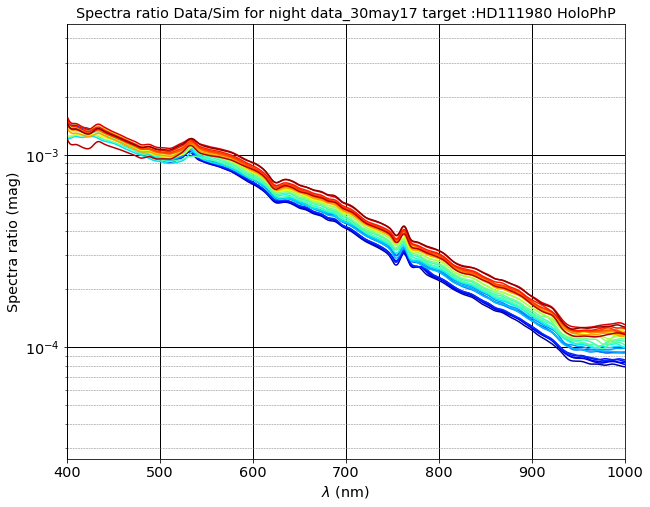

In [233]:
PlotSpectraLogRatioDataDivSimSmooth(all_spectrafiles,path_sim1,sel_obs_HoloPhP,SearchTagRe,wlshift,thetitle,
                     FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=400,XMAX=1000.,YMIN=0,YMAX=0)

In [234]:
the_ratio_file="ratiosmooth_HoloPhP.fits"
arr=SaveSpectraRatioDataDivSimSmooth(all_spectrafiles,path_sim1,sel_obs_HoloPhP,SearchTagRe,wlshift,the_ratio_file,FLAG_WL_CORRECTION,Flag_corr_wl=True)

## Spectrum ratio for HoloPhAg

In [235]:
thetitle="Spectra ratio Data/Sim for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloPhAg"

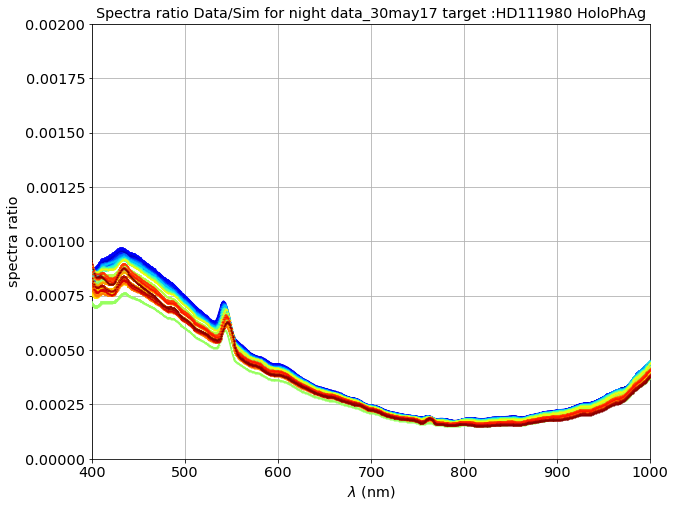

In [236]:
PlotSpectraRatioDataDivSimSmooth(all_spectrafiles,path_sim1,sel_obs_HoloPhAg,SearchTagRe,wlshift,thetitle,
                     FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=400,XMAX=1000.,YMIN=0,YMAX=0.002)

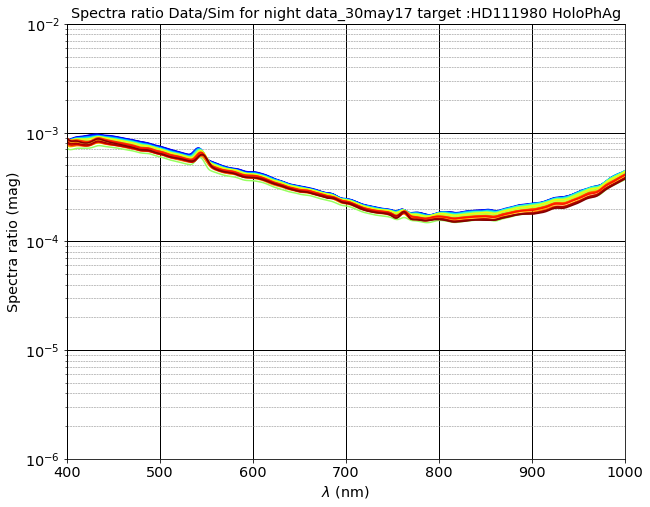

In [237]:
PlotSpectraLogRatioDataDivSimSmooth(all_spectrafiles,path_sim1,sel_obs_HoloPhAg,SearchTagRe,wlshift,thetitle,
                     FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=400,XMAX=1000.,YMIN=1e-6,YMAX=1e-2)

In [238]:
the_ratio_file="ratiosmooth_HoloPhAg.fits"
arr=SaveSpectraRatioDataDivSimSmooth(all_spectrafiles,path_sim1,sel_obs_HoloPhAg,SearchTagRe,wlshift,the_ratio_file,FLAG_WL_CORRECTION,Flag_corr_wl=True)              

## Spectrum ratio for HoloAmAg

In [239]:
thetitle="Spectra ratio Data/Sim for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloAmAg"

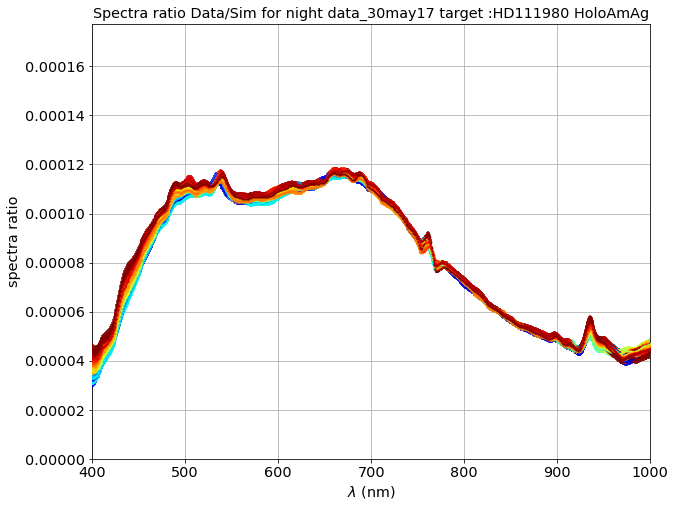

In [240]:
PlotSpectraRatioDataDivSimSmooth(all_spectrafiles,path_sim2,sel_obs_HoloAmAg,SearchTagRe,wlshift,thetitle,
                     FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=400,XMAX=1000.,YMIN=0,YMAX=0)

the_Y_min,the_Y_max = 1.00161184964e-05 0.000341145066648


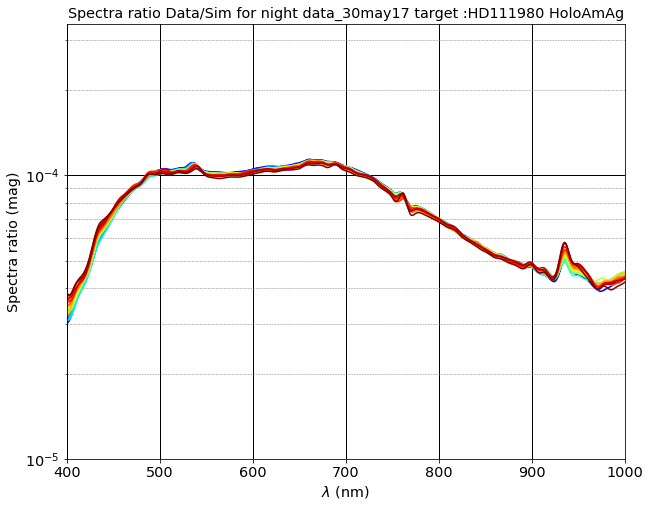

In [241]:
PlotSpectraLogRatioDataDivSimSmooth(all_spectrafiles,path_sim3,sel_obs_HoloAmAg,SearchTagRe,wlshift,thetitle,
                     FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=400,XMAX=1000.,YMIN=0,YMAX=0)

In [242]:
the_ratio_file="ratiosmooth_HoloAmAg.fits"
arr=SaveSpectraRatioDataDivSimSmooth(all_spectrafiles,path_sim1,sel_obs_HoloAmAg,SearchTagRe,wlshift,the_ratio_file,FLAG_WL_CORRECTION,Flag_corr_wl=True)    